In [1]:
##installs pytorch on a cuda-capable windows machine using pip

%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

%pip install torchsummary

%pip install numpy

%pip install matplotlib

%pip install opencv-python

%pip install scikit-learn

%pip install pandas

%pip install tqdm

%pip install pickle5

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pickle5
Note: you may

  error: subprocess-exited-with-error
  
  × Building wheel for pickle5 (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-311\pickle5
      copying pickle5\pickle.py -> build\lib.win-amd64-cpython-311\pickle5
      copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-311\pickle5
      copying pickle5\__init__.py -> build\lib.win-amd64-cpython-311\pickle5
      creating build\lib.win-amd64-cpython-311\pickle5\test
      copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-311\pickle5\test
      copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-311\pickle5\test
      copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-311\pickle5\test
      copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-311\pickle5\test
      running build_ext
      building 'pickle5._pickle' exte

In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [2]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda = torch.cuda.is_available()
print(cuda)

Current Working Directory: progettoVIPM
True


In [3]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset
from utils.extractNeuralFeatures import extract_features

In [4]:
chosen_net = networks.MOBILENET
print("Original classification layers:{}".format(chosen_net.value[1]))

Original classification layers:MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv

In [5]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu


linear_layers_to_remove = 2
X_train_t, X_train_n, y_train, X_test_t, X_test_n, y_test, fine_tune_layers, modified_net = extract_features(train_set=datasets.TRAINING_80,
                                                                                            test_set=datasets.VALIDATION_20,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=linear_layers_to_remove, 
                                                                                            cuda=cuda)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("---------------------------------------------------------------------------------")
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Found an existing set of features in: ./Storage/neural_features/Train_MobileNetV3_small_minus2_training_set_80%.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Train: 4016
Feature vector shape of Train: (4016, 576)
Label vector shape of Train: (4016,)
---------------------------------------------------------------------------------
Found an existing set of features in: ./Storage/neural_features/Test_MobileNetV3_small_minus2_train_set.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Test: 1004
Feature vector shape of Test: (1004, 576)
Label vector shape of Test: (1004,)
---------------------------------------------------------------------------------
Original classification layers:Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswis

In [6]:
from utils.fine_tune_pytorch import fine_tune_network_layers, eval_model_on_test_set, train_model
from copy import deepcopy
from utils.loadersAndEnums import dataloader_stratified_kfold
from utils.extractNeuralFeatures import extract_features_from_dataloader
from IPython.display import clear_output

In [ ]:
for param in fine_tune_layers.parameters():
    print(param.requires_grad)
    
loss_function = torch.nn.CrossEntropyLoss()

model = deepcopy(fine_tune_layers)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 200
batch_size = 64
k_for_accuracy = 5

stratified_kFold = False

if stratified_kFold:
    dataloaders = dataloader_stratified_kfold(dataset=datasets.TRAINING_80, k=5, network_input_size=227, batch_size=1, shuffle=False, cuda=True, transform=None, y_cuda=None)
    trained_models = []
    models_losses = []
    models_accuracies = []
    models_k_accuracies = []
    i = 0
    for train_val_loader in dataloaders:
        clear_output()
        print("-------------------Training on {} fold-------------------".format(i+1))
        train_loader = train_val_loader[0]
        val_loader = train_val_loader[1]
        x_train, y_train = extract_features_from_dataloader(loader=train_loader, out_features = 4096,transfer_network=modified_net, dataset_type="labelled")
        x_val, y_val = extract_features_from_dataloader(loader=val_loader, out_features = 4096,transfer_network=modified_net, dataset_type="labelled")
        
        fold_net = deepcopy(model)

        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
        trained_model, losses, accuracies, k_accuracies = fine_tune_network_layers(cuda=cuda, model=fold_net, x_train =x_train, y_train=y_train, n_epochs=n_epochs,
                                                                                 batch_size=batch_size,loss_function=loss_function, optimizer=optimizer, k_for_accuracy= k_for_accuracy)
        trained_models.append(trained_model)
        models_losses.append(losses)
        models_accuracies.append(accuracies)
        models_k_accuracies.append(k_accuracies)
        i += 1
        print("---------------------------------------------------------")
else:
    trained_model, losses, accuracies, k_accuracies = fine_tune_network_layers(cuda, model=model, x_train=X_train_t.cuda(), y_train=y_train, n_epochs=n_epochs,
                                                 batch_size=batch_size, loss_function=loss_function, optimizer=optimizer, k_for_accuracy= k_for_accuracy)


True
True
True
True
------------------Layers to fine-tune------------------
Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=251, bias=True)
)
-------------------------------------------------------
EPOCH 1:
---------------------Training---------------------
Batch 10 di 57
Batch 20 di 57
Batch 30 di 57
Batch 40 di 57
Batch 50 di 57
Training Loss: 5.596183107610335, Accuracy: 0.30428769017980634%, 5-Accuracy: 2.2130013831258646%
--------------------------------------------------
--------------------Validation--------------------
Validation Loss: 5.561548301151821, Accuracy: 0.49875311720698257%, 5-Accuracy: 3.2418952618453867%
EPOCH 2:
---------------------Training---------------------
Batch 10 di 57
Batch 20 di 57
Batch 30 di 57
Batch 40 di 57
Batch 50 di 57
Training Loss: 5.5921119388781095, Accuracy: 0.4426002766251729%, 5-Accuracy: 1.8257261410788381%
---------

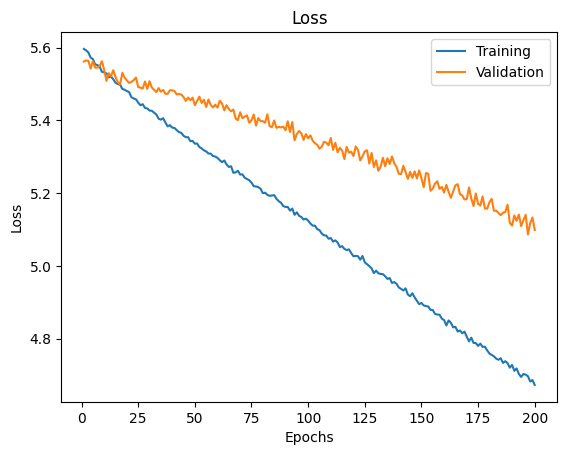

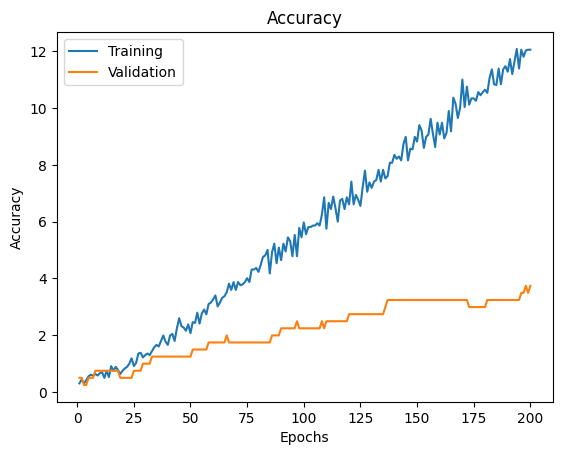

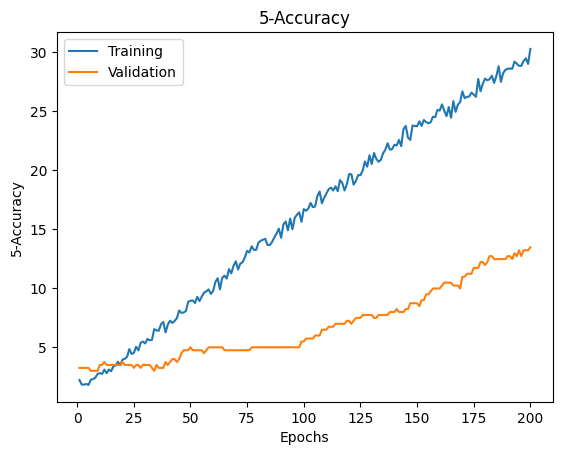

In [23]:

def plot(history, type, model_name):
  x_plot = list(range(1,len(history)+1))
  plt.figure()
  plt.title(type)
  plt.xlabel('Epochs')
  plt.ylabel(type)
  plt.plot(x_plot, history[:,0])
  plt.plot(x_plot, history[:,1])
  plt.legend(['Training', 'Validation'])
  plt.savefig("./Transfer_Learning/models_plots/MobileNetV3_small/{}_{}.png".format(type,model_name))

# print(losses)
if stratified_kFold:
  for i in range(5):
    model_name = "minus{}_{}e_{}bsize_80_20_split_fold{}".format(linear_layers_to_remove, n_epochs, batch_size, i+1)
    plot(models_losses[i], "Loss", model_name=model_name)
    plot(models_accuracies[i], "Accuracy", model_name=model_name)
    plot(models_k_accuracies[i], f"{k_for_accuracy}-Accuracy", model_name=model_name)
else:
  model_name = "minus{}_{}e_{}bsize_80_20_split".format(linear_layers_to_remove,n_epochs, batch_size)
  plot(losses, "Loss", model_name=model_name)
  plot(accuracies, "Accuracy", model_name=model_name)
  plot(k_accuracies, f"{k_for_accuracy}-Accuracy", model_name=model_name)

In [24]:
if stratified_kFold:
  for i in range(5):
    print("model of fold: {}".format(i+1))
    model_name = "finetunedMobileNetV3_small_minus{}_{}e_{}bsize_80_20_split_fold{}".format(linear_layers_to_remove, n_epochs, batch_size, i+1)
    cm = eval_model_on_test_set(trained_models[i], model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
else:
  model_name = "finetunedMobileNetV3_small_minus{}_{}e_{}bsize_80_20_split".format(linear_layers_to_remove, n_epochs, batch_size)
  cm = eval_model_on_test_set(trained_model, model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)
  np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
  print("CM filename: {}".format("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name)))
  torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
  print("Model saved at: {}".format("./Storage/models/Neural_models/{}.pth".format(model_name)))

100%|██████████| 1004/1004 [00:00<00:00, 1091.53it/s]

Accuracy: 6.47410358565737 %
5-Accuracy: 18.426294820717132
CM filename: ./Transfer_Learning/model_metrics/ConfM_finetunedMobileNetV3_small_minus2_200e_64bsize_80_20_split.npy
Model saved at: ./Storage/models/Neural_models/finetunedMobileNetV3_small_minus2_200e_64bsize_80_20_split.pth


In [ ]:
chosen_net = networks.MOBILENET
print("Original classification layers:{}".format(chosen_net.value[1]))
print(chosen_net.value[1].features)

In [ ]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu

linear_layers_to_remove = 3
X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers, modified_net = extract_features(train_set=datasets.TRAINING_80,
                                                                                            test_set=datasets.VALIDATION_20,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=linear_layers_to_remove, 
                                                                                            cuda=cuda, middle=True)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("---------------------------------------------------------------------------------")
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

In [6]:
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def model_building(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.savefig("./Transfer_Learning/model_metrics/ConfM_{}.pdf".format(model_name))
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    with open('./Storage/models/{}.pkl'.format(model_name),'wb') as f:
        pickle.dump(model,f)
    return acc

In [ ]:
array = []
for i in range(0,len(X_train_ale_n)):
    array.append(np.matrix.flatten(X_train_ale_n[i]))
array = np.array(array)
print(array.shape)
X_train_ale_n= array

array = []
for i in range(0,len(X_test_ale_n)):
    array.append(np.matrix.flatten(X_test_ale_n[i]))
array = np.array(array)
print(array.shape)
X_test_ale_n = array


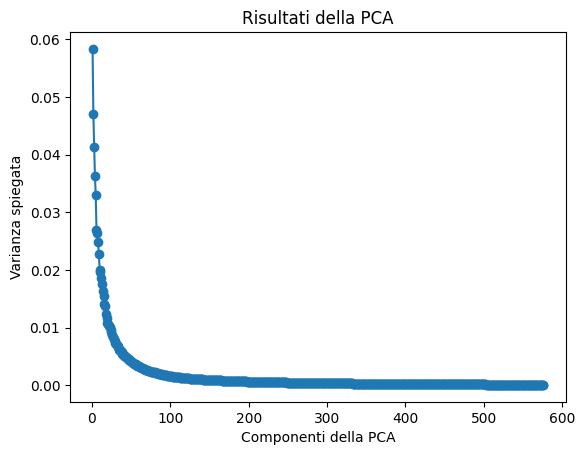

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

is_pca_used = True

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train_n)
pca = PCA().fit(scaled_data)

plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()


In [9]:
components = 300
pca = PCA(n_components=components).fit(scaled_data)
X_train_pca = pca.transform(scaled_data)
print("Final input shape train: {}".format(X_train_pca.shape))

scaled_data = scaler.fit_transform(X_test_n)
x_test_pca = pca.transform(scaled_data)
print("Final input shape test: {}".format(x_test_pca.shape))

Final input shape train: (4016, 300)
Final input shape test: (1004, 300)


 14%|█▍        | 1/7 [09:01<54:08, 541.46s/it]

Linear Support Vector obtained following accuracy: 0.099601593625498


 29%|██▊       | 2/7 [10:11<22:00, 264.04s/it]

Rbf Support Vector obtained following accuracy: 0.1942231075697211


 43%|████▎     | 3/7 [11:18<11:35, 173.95s/it]

KNN with 1 neighbors obtained following accuracy: 0.09063745019920319


 57%|█████▋    | 4/7 [12:20<06:30, 130.07s/it]

KNN with 10 neighbors obtained following accuracy: 0.10458167330677291


 71%|███████▏  | 5/7 [13:25<03:32, 106.40s/it]

KNN with 20 neighbors obtained following accuracy: 0.12151394422310757


 86%|████████▌ | 6/7 [14:29<01:32, 92.07s/it] 

KNN with 50 neighbors obtained following accuracy: 0.12350597609561753


100%|██████████| 7/7 [15:36<00:00, 133.82s/it]

Naive Bayes obtained following accuracy: 0.12848605577689243


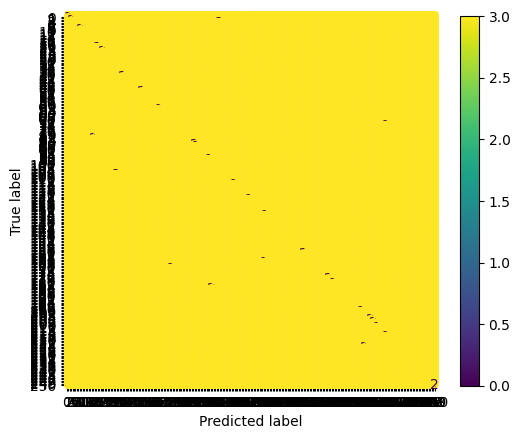

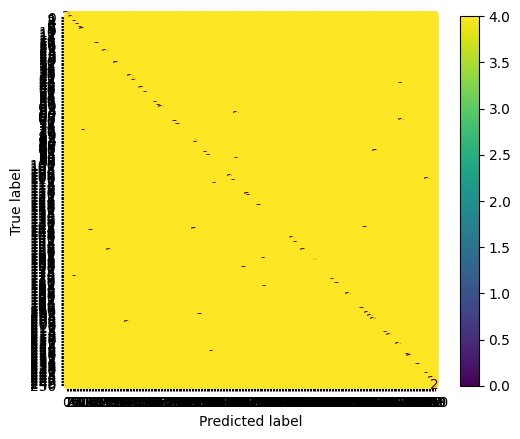

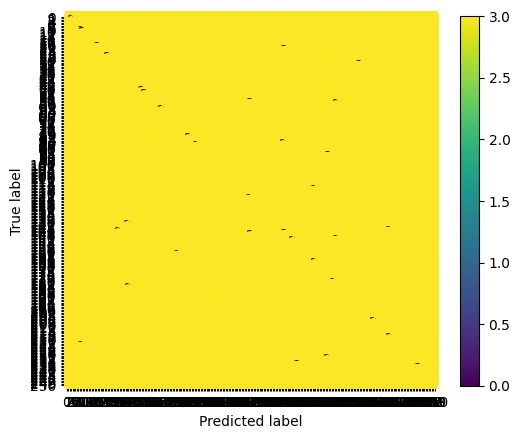

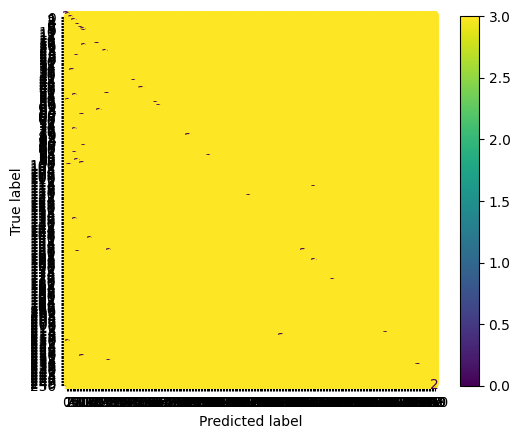

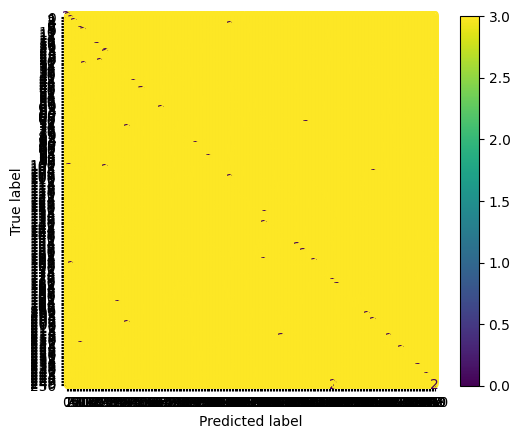

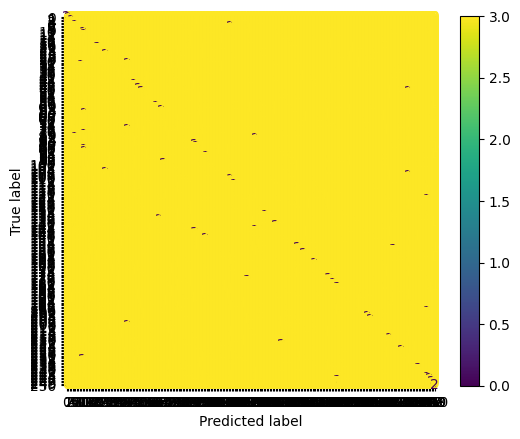

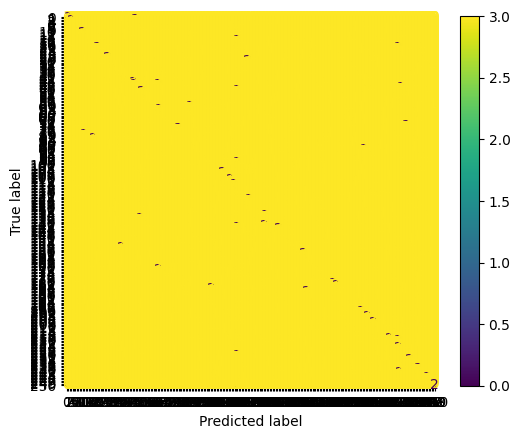

In [10]:

from enum import Enum
class ml_models(Enum):
    LINEAR_SVC = [LinearSVC(), "Linear Support Vector"]
    RBF_SVC = [SVC(kernel="rbf"), "Rbf Support Vector"]
    # RANDOM_FOREST = [RandomForestClassifier(), "Random Forest"]
    # BOOSTED_FOREST = [GradientBoostingClassifier(), "Gradient Boosting Classifier"]
    KNN_1 = [KNeighborsClassifier(n_neighbors=1), "KNN with 1 neighbors"]
    KNN_10 = [KNeighborsClassifier(n_neighbors=10), "KNN with 10 neighbors"]
    KNN_20 = [KNeighborsClassifier(n_neighbors=20), "KNN with 20 neighbors"]
    KNN_50 = [KNeighborsClassifier(n_neighbors=50), "KNN with 50 neighbors"]
    NAIVE_BAYES = [GaussianNB(), "Naive Bayes"]

is_pca_used = True
extra = [False, "_mixed_dataset"]

x_train = X_train_n
x_test = X_test_n
if is_pca_used:
    x_train = X_train_pca
    x_test =x_test_pca
model_accuracies = []
for model in tqdm(ml_models):    
    model_name = "{}_from_{}_minus{}".format(model.value[1], chosen_net.value[2], linear_layers_to_remove)
    if is_pca_used:
        model_name += "_pca"
    if extra[0]:
        model_name += extra[1]
    score = model_building(model.value[0], model_name, x_train, x_test, y_train, y_test)
    print("{} obtained following accuracy: {}".format(model.value[1],score))
    model_accuracies.append([model_name, score])
model_accuracies = np.array(model_accuracies)
accuracies_filename = "./Transfer_Learning/model_metrics/Accuracies_{}_minus{}".format(chosen_net.value[2], linear_layers_to_remove)
if is_pca_used:
    accuracies_filename += "_pca"
if extra[0]:
        model_name += extra[1]

np.save("{}.npy".format(accuracies_filename), model_accuracies)